In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio as ft

In [3]:
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')
from syslss import hpixsum, cl2xi, xi2cl

In [4]:
class AngularClustering2D(object):
    """
    Clustering Statistics Cell and Omega
    """
    
    def __init__(self, data, random, 
                 sysmap, selection_function=None, mask=None, nside=256, hpmap=False):
        if hpmap:
            datamap = np.copy(data)
            randmap = np.copy(random)
        else:
            datamap = hpixsum(nside, data.RA, data.DEC, value=data.Weight)
            randmap = hpixsum(nside, random.RA, random.DEC, value=random.Weight)
        if selection_function is None:
            selection_function = np.ones(randmap.shape)
        delta   = np.zeros(datamap.shape)
        
        if mask is None:
            mask    = (randmap != 0.0) & (selection_function !=0.0)
        randsel = randmap * selection_function
        sf      = datamap[mask].sum() / randsel[mask].sum()
        delta[mask] = datamap[mask]/ (sf * randsel[mask]) - 1.0
        
        #
        delta2 = np.zeros(12*256**2)
        sf2  = (sysmap[mask]*randmap[mask]).sum() / randmap[mask].sum()
        delta2[mask] = sysmap[mask] / (sf2 * randmap[mask]) - 1.0
        #
        #
        print(np.sum(delta2[mask]*randmap[mask]))
        print(np.sum(delta[mask]*randsel[mask]))
        self.delta  = delta
        self.delta2 = delta2
        self.weight = randmap
        self.nside = nside
        self.mask  = mask
    
    def run(self, LMAX=None):
        if LMAX is None:
            LMAX           = 3*self.nside-1
        else:
            assert LMAX <=  3*self.nside-1
        x, w = np.polynomial.legendre.leggauss(LMAX)
        #map
        mapmasked       = hp.ma(self.delta * self.weight)
        mapmasked.mask  = np.logical_not(self.mask)
        #
        #map2
        mapmasked2       = hp.ma(self.delta2)
        mapmasked2.mask  = np.logical_not(self.mask)        
        clmap           = hp.anafast(mapmasked.filled(), map2=mapmasked2.filled(), lmax=LMAX)
        ximap           = cl2xi(clmap, x)
        #mask
        maskmasked      = hp.ma(self.weight)
        maskmasked.mask = np.logical_not(self.mask)
        clmask          = hp.anafast(maskmasked.filled(), lmax=LMAX)
        ximask          = cl2xi(clmask, x)
        # correct for the mask
        xifinal         = ximap / ximask
        clfinal         = xi2cl(x, w, xifinal, LMAX)
        # update
        output = {}
        output['attr'] = {'nside':self.nside, 'lmax':LMAX}
        output['cl'] = (np.arange(clfinal.size), clfinal)
        output['xi'] = (np.rad2deg(np.arccos(x)), xifinal)
        return output


In [5]:
# read elgmap and ranmap
elgmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/eBOSS.ELGhpmap.fits')
ranmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/eboss/eBOSS.ELGRANhpmap.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [6]:
path3 = '/global/cscratch1/sd/mehdi/dr5_anand/eboss/'
outdata_m, h = ft.read(path3 + "ebossELGngal-features-masked.fits", header=True)

In [7]:
# hp.write_map('/global/cscratch1/sd/mehdi/dr5_anand/march22/nn-weights-hpmap256.fits', nnwmap, fits_IDL=False)
# hp.write_map('/global/cscratch1/sd/mehdi/dr5_anand/march22/lin-weights-hpmap256.fits', liwmap, fits_IDL=False)
nnwmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/march22/nn-weights-hpmap256.fits')
liwmap = hp.read_map('/global/cscratch1/sd/mehdi/dr5_anand/march22/lin-weights-hpmap256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
# find a common mask
mask1 = ranmap != 0.0
mask2 = liwmap != 0.0
mask3 = nnwmap !=0.0

In [9]:
ebv = np.zeros(12*256**2)
ebv[outdata_m['hpix']] = outdata_m['features'][:,0]

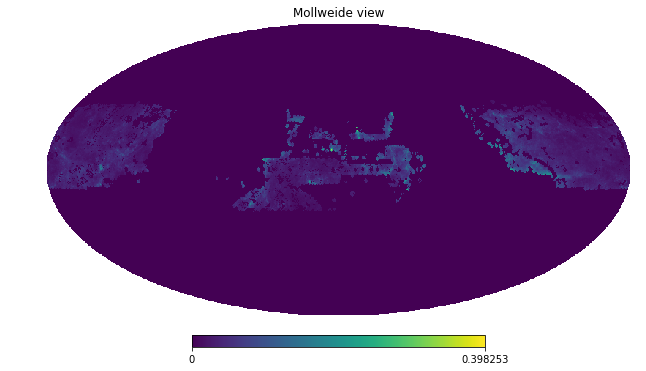

In [10]:
hp.mollview(ebv)

In [11]:
ebv.min()

0.0

In [12]:
results = []
for select_fun in [np.ones_like(ranmap), liwmap, nnwmap]:
    dr5 = AngularClustering2D(elgmap, ranmap, ebv,
                                 selection_function=select_fun, hpmap=True, mask=mask1)
    results.append(dr5.run())

12894.8071377
-3.97903932026e-13
12894.8071377
-1.36424205266e-12
12894.8071377
6.48014975013e-11


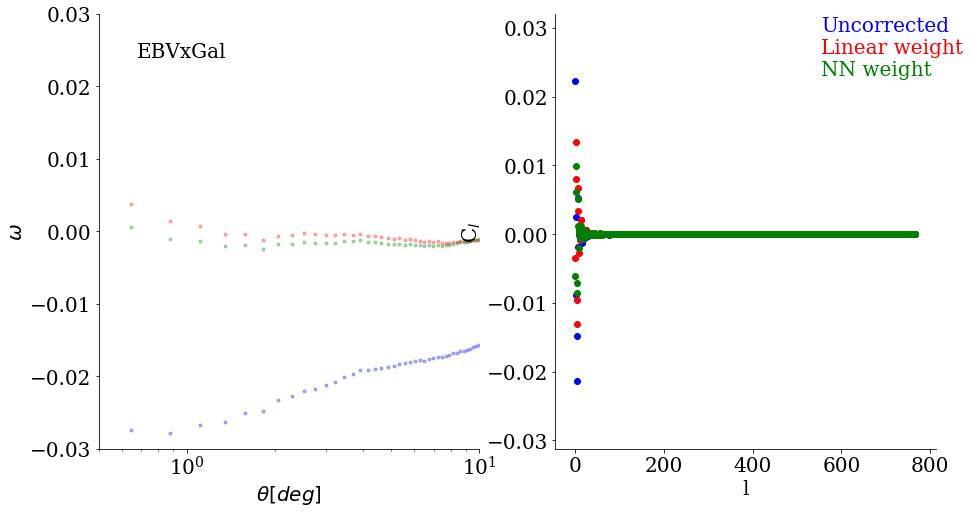

In [15]:
names = ['Uncorrected','Linear weight', 'NN weight']
c = ['blue', 'red', 'green']
ltl = ['-','-.',':']
plt.rc('font', family='serif', size=20)
plt.rc('axes.spines', right=False, top=False)
from matplotlib.ticker import FormatStrFormatter




f,a = plt.subplots(ncols=2, figsize=(15,8))
pl = ['uni','lin','nn']
#
#
for i, result_i in enumerate(results):
#     tp, xip = np.load('/global/cscratch1/sd/mehdi/dr5_anand/march22/xi-cl-dr5_'+pl[i]+'.npy')
    t,xi = result_i['xi']
    l,cl = result_i['cl']
#     a[0].plot(tp, xip, color=c[i], linestyle=ltl[i], marker='+', alpha=0.8)
    a[0].plot(t, xi, color=c[i], linestyle='None', marker='.', alpha=0.3)
    a[1].scatter(l, cl, color=c[i])
#     scatterit(a[1], l, cl,np.arange(1, 1000, 10),  shift=0.4*i, marker='.', color=c[i])
    a[1].text(0.7, 0.96-i*0.05, names[i], color=c[i], transform=a[1].transAxes)

# 0
# a[0].set_yscale('log')
# a[0].axis([.22,10, 1.e-5, 1.e-1])
a[0].text(0.1, 0.9, 'EBVxGal', transform=a[0].transAxes)
a[0].set_xscale('log')
a[0].axis([0.5, 10., -0.03, 0.03])
a[0].set_xlabel(r'$\theta[deg]$')
a[0].set_ylabel(r'$\omega$')
# f.delaxes(a[0])
# 1
# a[1].set_xscale('log')
# a[1].axis([0.8, 1000, -1.e-3, 1.e-3])
# a[1].set_xlim([0.8, 1000])
a[1].set_xlabel('l')
a[1].set_ylabel(r'C$_{l}$')
a[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# plt.savefig('./figs/xi-cl-dr5.pdf', bbox_inches='tight')

In [1]:
ls /global/cscratch1/sd/mehdi/dr5_anand/eboss/

eBOSS.ELG.dr5.fits      ebossELGngal-features-masked.fits
eBOSS.ELGRANhpmap.fits  ebossELGngal-features.fits
eBOSS.ELGhpmap.fits
